In [46]:
import numpy as np


class RPCA:
    def __init__(self, lmd=None, mu=None, max_rank=None,
                 max_iter=50, tolerance=1e-6):

        self.lmd = lmd
        self.mu = mu
        self.max_rank = max_rank
        self.max_iter = max_iter
        self.tolerance = tolerance
        self.is_stable = False
        self.low_rank = 0
        self.sparse = 0
        self.rank = 0

    @staticmethod
    def neglect(mat, tolerance):
        return np.sign(mat) * np.maximum(np.abs(mat) - tolerance, 0)

    def shrink_singular_values(self, mat):
        u, sigma, v_h = np.linalg.svd(mat, full_matrices=False)
        tau = 1.0 / self.mu
        sigma = sigma[sigma > tau] - tau
        r = len(sigma)

        if self.max_rank and r > self.max_rank:
            sigma = sigma[:self.max_rank]
            r = self.max_rank

        return np.dot(u[:, :r] * sigma, v_h[:r, :]), r

    def fit(self, mat):
        rows, cols = mat.shape
        sparse_part = np.zeros((rows, cols))
        lag_ratio = np.zeros((rows, cols))

        if not self.lmd:
            self.lmd = 1 / np.sqrt(max(rows, cols))
        if not self.mu:
            self.mu = (rows * cols) / (4 * np.sum(np.abs(mat)))

        tolerance_level = self.tolerance * np.linalg.norm(mat, ord='fro')

        low_rank_part = 0
        rank = 0

        for _ in range(self.max_iter):
            low_rank_part, rank = self.shrink_singular_values(mat - sparse_part + lag_ratio / self.mu)
            sparse_part = self.neglect(mat - low_rank_part + lag_ratio / self.mu, self.lmd / self.mu)

            res = mat - low_rank_part - sparse_part
            res_n = np.linalg.norm(res, ord='fro')

            if res_n <= tolerance_level:
                self.is_stable = True
                break

            lag_ratio += self.mu * res

        self.low_rank = low_rank_part
        self.sparse = sparse_part
        self.rank = rank

In [47]:
def l0_norm(x: np.ndarray) -> float:
    return np.count_nonzero(x)


def l1_norm(x: np.ndarray) -> float:
    return np.abs(x).sum()


def fro_norm(x: np.ndarray) -> float:
    return np.linalg.norm(x, ord='fro')

In [48]:
def filter_elements(indices, mat):
    filt = np.zeros_like(mat)

    for i, j in indices:
        filt[i, j] = mat[i, j]

    return filt

In [49]:
import scipy.stats as sts


def test_synth(dim, noise_rate):
    rank = int(0.05 * dim)
    err_count = int(noise_rate * dim * dim)

    m1 = sts.norm.rvs(0, np.sqrt(1 / dim), size=(dim, rank))
    m2 = sts.norm.rvs(0, np.sqrt(1 / dim), size=(dim, rank))
    low_rank_mat = m1 @ m2.T

    noise = sts.bernoulli.rvs(p=0.5, size=(dim, dim)) * 2 - 1
    index_list = np.mgrid[0:dim, 0:dim].reshape(2, -1).T[
        np.random.choice(dim ** 2, size=err_count, replace=False)
    ]

    sparse_mat = np.zeros_like(noise)

    for i, j in index_list:
        sparse_mat[i, j] = noise[i, j]

    model = RPCA(max_iter=10)
    in_mat = low_rank_mat + sparse_mat
    model.fit(in_mat)

    print(f'\tDifference norm: {fro_norm(model.low_rank - low_rank_mat) / fro_norm(low_rank_mat)}')

In [50]:
import pandas as pd

dim_list = [100, 500, 1000]
noise_rate_list = [0.05, 0.01]

results = {}

for noise in noise_rate_list:
    df_results = pd.DataFrame()

    for dim in dim_list:
        print(f"dim={dim}, noise={noise}")
        test_result = test_synth(dim, noise)
        df_results = pd.concat([df_results, pd.DataFrame(test_result, index=[0])], ignore_index=True)

    results[noise] = df_results

dim=100, noise=0.05
	Difference norm: 3.4335997626129013
dim=500, noise=0.05
	Difference norm: 16.132537526768267
dim=1000, noise=0.05
	Difference norm: 25.56132764378272
dim=100, noise=0.01
	Difference norm: 2.0041443824434726
dim=500, noise=0.01
	Difference norm: 7.830647499301998
dim=1000, noise=0.01
	Difference norm: 12.10335940216096


In [51]:
import os

os.getcwd()

'/mnt/c/Users/danie/PycharmProjects/ml-2024/hw3'

In [52]:
from PIL import Image
import matplotlib.pyplot as plt

def decompose_image(file_path):
    with Image.open(file_path) as img:
        img = img.convert('L')
        image_width, image_height = img.size
        img_array = np.column_stack(np.array(img).flatten())

        model = RPCA(max_iter=500)
        model.fit(img_array)

        original_2d = img_array.reshape((image_height, image_width))
        low_rank_2d = model.low_rank.reshape((image_height, image_width))
        sparse_2d = model.sparse.reshape((image_height, image_width))

        fig, axes = plt.subplots(1, 3, figsize=(12, 4))

        axes[0].imshow(original_2d, cmap='gray')
        axes[0].set_title("Original")
        axes[0].axis('off')

        axes[1].imshow(low_rank_2d, cmap='gray')
        axes[1].set_title("Low-Rank")
        axes[1].axis('off')

        axes[2].imshow(sparse_2d, cmap='gray')
        axes[2].set_title("Sparse")
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()

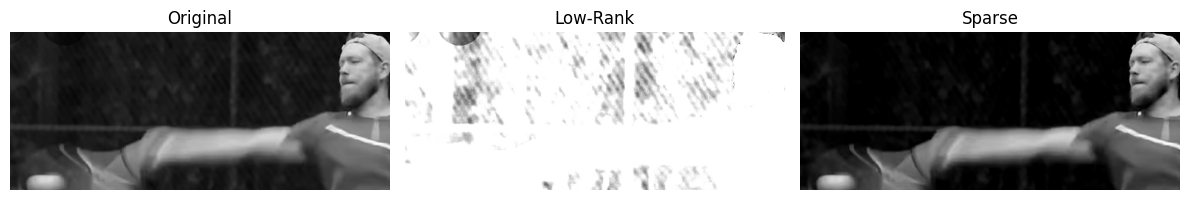

In [53]:
decompose_image('t3_image/tennis.png')

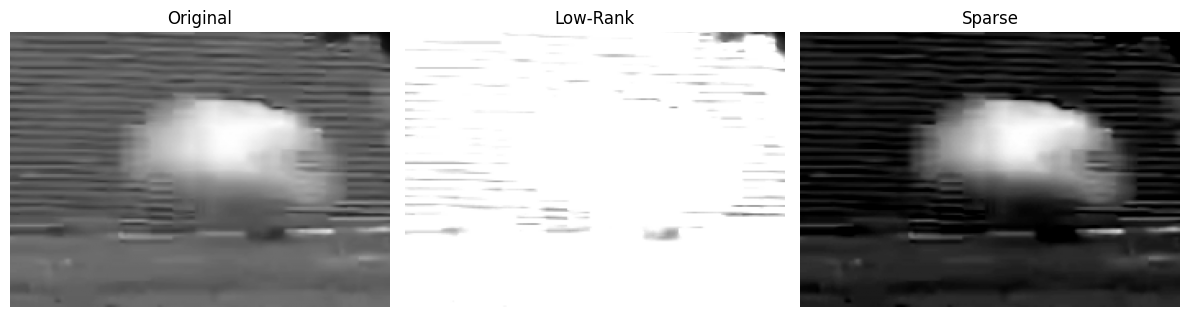

In [54]:
decompose_image('t3_image/football.png')